load the necessary modules

In [282]:
%load_ext autoreload
%autoreload 2
import iarray as ia
import run2019

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ia.plt.rcParams['font.size'] = 15

# run2019 analysis

## expected rate

### neutrino flux

The neutrino reactor flux is
$$
\frac{d\Phi}{d E_{\nu}} = \frac{ d^3 N_{\nu} }{ d E_{\nu} d\sigma dt }
$$
with units counts/MeV/cm$^2$/s

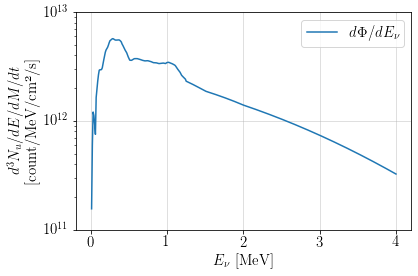

In [821]:
flux_nu = ia.genfromcsv(
    "data/reactorFlux.csv", 
    x = dict( name=r"$E_\nu$", unit=ia.MeV, dim="Enu" ), 
    y = dict( name=r"$d\Phi/d E_\nu$", unit=ia.ureg("counts/MeV/cm^2/s") ) 
)
flux_nu.xplot(ylabel="$d^3N_\nu/dE/dM/dt$", yscale="log")
plt.ylim((1e11, 1e13))
plt.grid(True)

![alt text](data/fluxReactor.png "the title")

### cross section

The Standard Model CEvNS cross section is
$$
\frac{ d\sigma }{d E_{\rm R}} = \frac{G_F^2}{4\pi} Q_W^2 \left(
    1 - \frac{E_R}{E_\nu} + (E_R - M)\frac{E_R}{2E_\nu^2}
\right) M F^2
$$
where
$$
G_F = 1.1663787 \cdot 10^{-5} \text{GeV}^{-2}\quad \text{Fermi constant}
\\
Q_W = N = 14 \quad \text{weak nuclear charge}
\\
M = 28.085 \text{u} = 28.085 \cdot 9.314 \cdot 10^5 \text{keV}\quad \text{Silicon atomic mass}
\\
F = 1 \quad \text{nuclear form factor}
$$

In [214]:
E_R = ia.Coord(r"$E_{\rm R}$", "Er", ia.arange(0,2,.01)*ia.keV )
print( E_R )
print( flux_nu.xcoords[0] )

<xarray.DataArray '$E_{\\rm R}$' (Er: 200)>
<Quantity([0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.

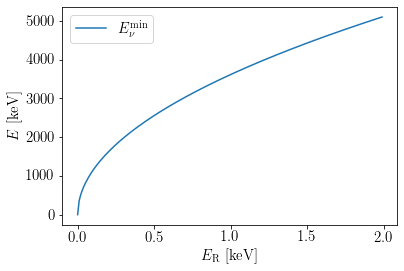

In [145]:
def E_nu_min(ER):
    M = run2019.M_Si_amu * ia.amu
    return ia.Array(r"$E_\nu^{\rm min}$", data = ( ER + ia.sqrt( ER**2 + 2*M*ER) )/2 )

E_nu_min( E_R ).xplot( ylabel=r"$E$" )

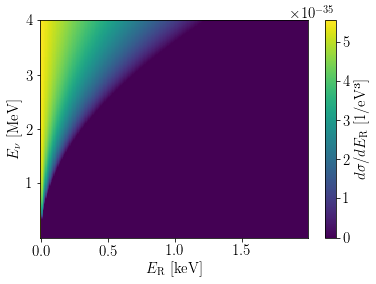

In [189]:
def dsigma__dE_R( ER, Enu ):
    M = run2019.M_Si_amu * ia.amu
    Enu_min = ia.Array(r"$E_\nu^{\rm min}$", data = ( ER + ia.sqrt( ER**2 + 2*M*ER) )/2 )
    F = 1
    QW = 14
    GF = 1.1663787e-5 / ia.GeV**2.
    data = GF**2./(4*ia.pi) * QW**2. * ( 1 - ER/Enu + ER*(ER - M)/2/Enu**2. ) * M * F**2.
    return ia.Array( r"$d\sigma/dE_{\rm R}$", data = data ).where( Enu > Enu_min, 0 )

dsigma__dE_R(E_R, flux_nu.get_coords(0)).xplot()

### recoil rate

The rate of recoil events is obtained by convoluting the neutrino flux with the cross section and multiplying by the number of Silicon nuclei per kg
$$
\frac{dR}{d E_R} = N_T \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d\Phi}{dE_\nu} \frac{d\sigma}{dE_R}
$$
which can be expressed as
$$
\frac{d^3N}{d E_R dM dt} = \frac{dN_T}{dM} \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d^3 N}{dE_\nu d\sigma dt} \frac{d\sigma}{dE_R}
$$
where
$$
E_\nu^\text{min} = \frac{1}{2} \left( E_R + \sqrt{ E_R^2 + 2ME_R } \right)
\\
\frac{dN_T}{dM} = \frac{6.022 \cdot 10^{23} }{28.084 \cdot 10^{-3} \text{kg}}
$$

However, the differential cross section is at natural units, while the neutrino flux is in SI. 
In order to make them compatible, the quantities are converted to barn.
$$
\text{SI:}\quad \text{cm}^2 = 10^{27}\text{mb}
\\
\text{natural:}\quad \text{GeV}^{-2} = \frac{1}{2.56819} \text{mb}
$$
dividing both gives
$$
\text{cm}^2\text{GeV}^2 = 2.56819 \cdot 10^{27}
$$

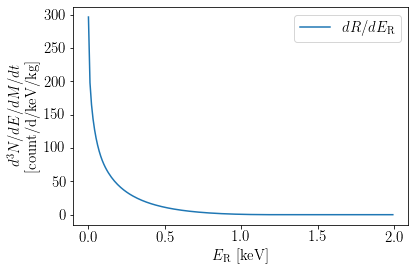

In [165]:
def dR__dE_R( E_R, flux_nu ):
    to_barn = ia.ureg( "cm^2.*GeV^2." )/2.568e27
    N_T = (6.022e23/(28.084 * ia.ureg.g) ).to('1/kg')
    return ia.Array(
        r"$dR/dE_{\rm R}$",
        data = N_T * flux_nu * dsigma__dE_R( E_R, flux_nu.xcoords[0] ) * to_barn
    ).integrate( flux_nu.xcoords[0].name )

dR__dE_R( E_R, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")

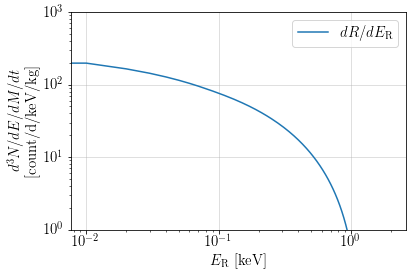

In [813]:
dR__dE_R( E_R, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", yscale="log", xscale="log", unit="count/keV/kg/day")
plt.ylim((1,1e3))
plt.grid(True)

![alt text](data/paperQuenching.png "the title")

Figure 4. Left: The expected recoil energy spectrum (blue dashed line); the visible energy spectrum
assuming a Lindhard Q factor (red solid line); the visible energy spectrum with Lindhard Q factor and
the effect of the detector efficiency (green dashed line). Right: Total event rate as a function of the
energy threshold for various quenching factors. The shaded area shows the expected signal region for a
threshold of 5σRMS ' 28 eV, and realistic quenching factors. Adapted from [9].

from: 1608.01565.pdf

### quenching factor

The quenching factor is defined as the fraction of the Silicon recoil energy which is converted to electron ionization energy,
$$
E_I = Q E_R
$$

To convertion from recoil energy to ionization energy,
$$
E_R \rightarrow E_I = Q E_R
$$
therefore
$$
f(E_R) \rightarrow f(Q E_R)
$$
furtheremore,
$$
\frac{df(E_R)}{dE_R} \rightarrow \frac{df(Q E_R)}{d(Q E_R)}
= \frac{dE_R}{d(Q E_R)} \frac{df(Q E_R)}{dE_R} 
$$

In the case the quenching factor is defined as a function of the ionization energy $Q = Q(E_I)$,
$$
\frac{dE_R}{dE_I} = \frac{d}{dE_I}\left(\frac{E_I}{Q(E_I)}\right)
= \left( \frac{1}{Q(E_I)} - \frac{E_I}{Q(E_I)^2} \frac{dQ(E_I)}{dE_I} \right)
$$

In the case the quenching factor is defined as a function of the recoil energy $Q = Q(E_R)$,
$$
\frac{dE_R}{dE_I} = \left( \frac{d}{dE_R}(Q(E_R) E_R) \right)^{-1} = \left( Q(E_R) + E_R \frac{dQ(E_R)}{dE_R} \right)^{-1}
$$
which converts into
$$
\frac{dE_R}{dE_I} = \left( Q(E_R) + E_R \frac{dQ(E_R)}{dE_R} \right)^{-1}
$$


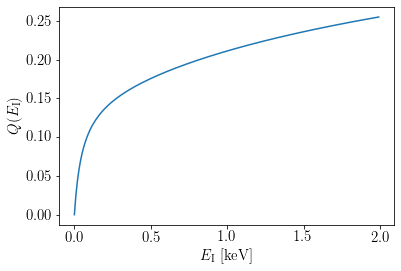

In [170]:
E_I = ia.Coord(r"$E_{\rm I}$", "Ei", ia.arange(0,2,.01)*ia.keV )

def Q(E_I):
    p0 = 56 * ia.keV**3.
    p1 = 1096 * ia.keV**2
    p2 = 382 * ia.keV
    p3 = 168 * ia.keV**2
    p4 = 155 * ia.keV
    N = p3*E_I + p4*E_I**2 + E_I**3
    D = p0 + p1*E_I + p2*E_I**2
    return ia.Array( r"$Q(E_{\rm I})$", data = N/D )

Q(E_I).xplot()

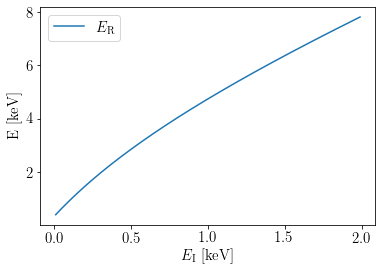

In [172]:
ia.Array( r"$E_{\rm R}$", data = E_I/Q(E_I) ).xplot(ylabel="$E$")

(0.05, 20)

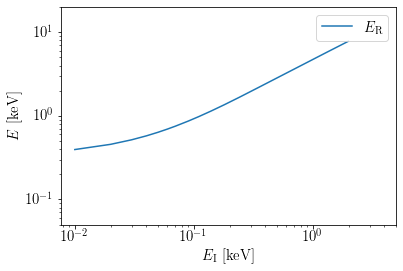

In [900]:
ia.Array( r"$E_{\rm R}$", data = E_I/Q(E_I) ).xplot(ylabel="$E$", xscale="log", yscale="log")
# ia.Array( r"$E_{\rm R}$", data = E_I/Q_Lindhard(E_I) ).xplot(ylabel="$E$", xscale="log", yscale="log")
plt.xlim((None, 5))
plt.ylim((0.05, 20))

![alt text](data/quenchingParametrized.png "the title")

### ionization rate

the ionization energy is obtained by computing the conversion factor between the Silicon recoil energy and the electron ionization energy
$$
\frac{dE_R}{dE_I}(E_I) = \frac{1}{Q(E_I)^2}\left( Q(E_I) - E_I \frac{dQ}{dE_I}(E_I) \right)
$$

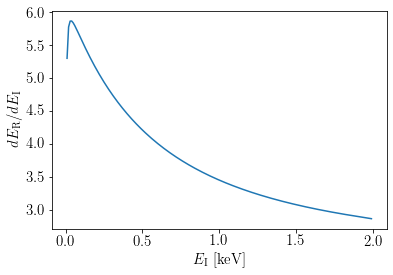

In [706]:
def dE_R__dE_I(E_I, Q):
    return ia.Array(
        r"$dE_{\rm R}/dE_{\rm I}$",
        data = 1./Q(E_I) - E_I/Q(E_I)**2 * Q(E_I).xdiff()
    )

dE_R__dE_I(E_I, Q).xplot()

the ionization rate is then
$$
\frac{dR}{dE_I}(E_I) = \frac{dE_R}{dE_I}(E_I) \frac{dR}{dE_R}(E_I)
$$

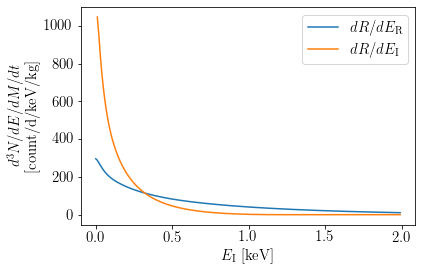

In [886]:
def dR__dE_I(E_I, Q, flux_nu):
    return ia.Array(
        r"$dR/dE_{\rm I}$",
        data = dR__dE_R(E_I, flux_nu) * dE_R__dE_I(E_I, Q)
    )

dR__dE_R( E_I*Q(E_I), flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
dR__dE_I( E_I, Q, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")

The comparison between the Silicon recoil and the electron ionization rates show that the rate is higher for the ionization

(1, 10000.0)

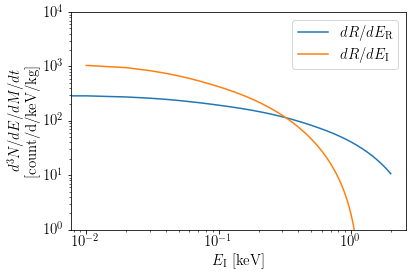

In [814]:
dR__dE_R( Q(E_I)*E_I, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
dR__dE_I( E_I, Q, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
plt.ylim( (1,1e4) )

(1, 10000.0)

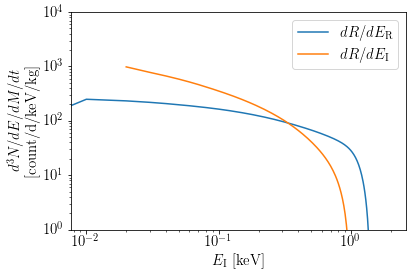

In [809]:
def Q_Lindhard(E_I):
    p0 = 0.173
    p1 = 0.307/ia.keV
    p2 = -0.856/ia.keV**2
    p3 = 1.684/ia.keV**3
    p4 = -1.801/ia.keV**4
    p5 = 0.783/ia.keV**5
    p6 = 5.9e-4*ia.keV
    p7 = 3.3e-6*ia.keV**2

    ret = p0 + p1*E_I + p2*E_I**2 + p3*E_I**3 + p4*E_I**4 + p5*E_I**5 + p6/E_I + p7/E_I**2
    return ia.Array( r"$Q_L(E_{\rm I})$", data = ret )

dR__dE_R( Q_Lindhard(E_I)*E_I, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
dR__dE_I( E_I, Q_Lindhard, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
plt.ylim((1,1e4))

![alt text](data/paperQuenching.png "the title")

Figure 4. Left: The expected recoil energy spectrum (blue dashed line); the visible energy spectrum
assuming a Lindhard Q factor (red solid line); the visible energy spectrum with Lindhard Q factor and
the effect of the detector efficiency (green dashed line). Right: Total event rate as a function of the
energy threshold for various quenching factors. The shaded area shows the expected signal region for a
threshold of 5σRMS ' 28 eV, and realistic quenching factors. Adapted from [9].

from: 1608.01565.pdf

In [894]:
print( dR__dE_R( (Q(E_I)*E_I)[1:], flux_nu ).integrate(E_I.name) )
print( dR__dE_I( E_I[1:], Q, flux_nu ).integrate(E_I.name) )

<xarray.DataArray '$dR/dE_{\\rm R}$' ()>
<Quantity(0.0014237687616598976, 'count / kilogram / second')>
<xarray.DataArray '$dR/dE_{\\rm I}$' ()>
<Quantity(0.0015933973150880044, 'count / kilogram / second')>


## acceptance

The acceptance is computed  by simulating events with given ionization energies and confirming the rate of reconstruction
$$
\frac{dN}{dE_I} = {\cal A}(E_{\rm I})\frac{dN_S}{dE_I},
$$

### simulation spectrum

In [553]:
import iarray as ia
def dNsim__dE_I( E_I, cut ):
    data = ia.genfromroot( 
        run2019.sim_files, 
        treename="hitSumm",  
        branches = {"E": ("oEnergy", "eV"), "hdu": "hdu"},
        cut = str(cut*run2019.excluded_hdu),
    )
    return data.xhistogram("hdu", centers=E_I, per_bin=True)

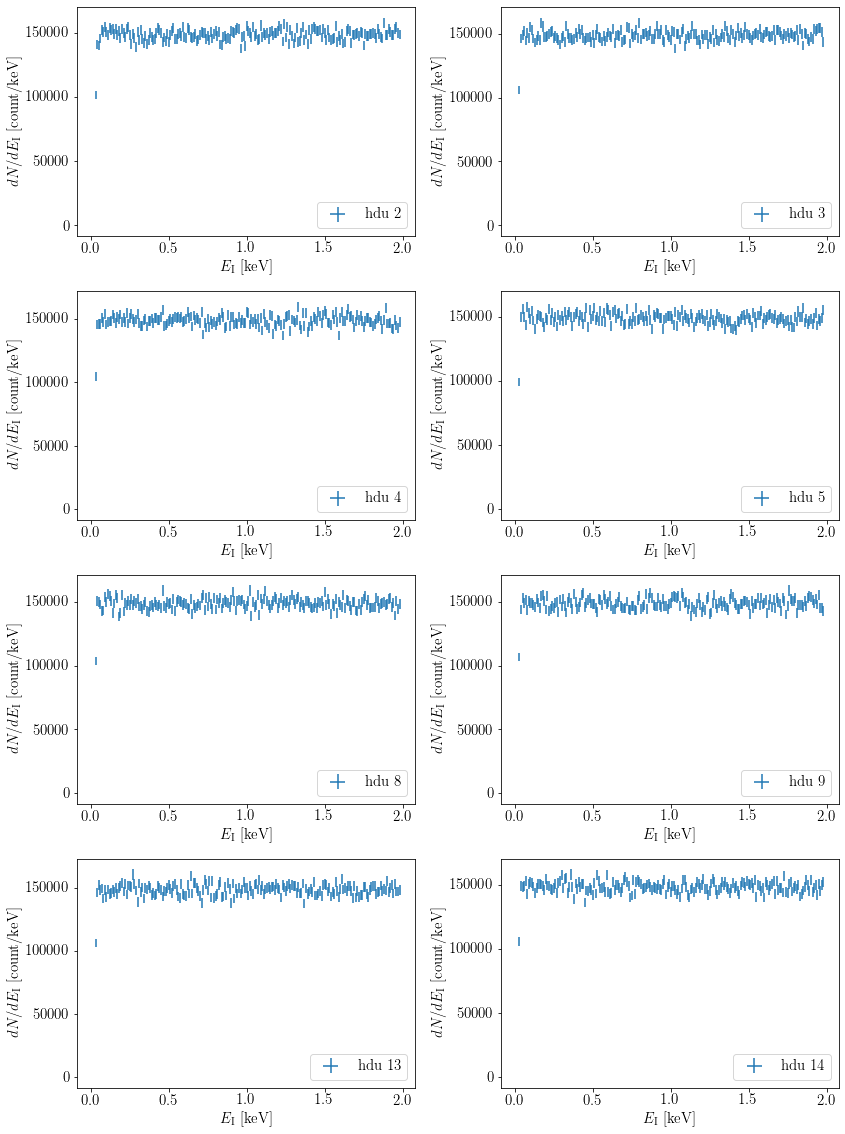

In [554]:
( 
    dNsim__dE_I( E_I, run2019.on_excl )
).errorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")

### matched spectrum

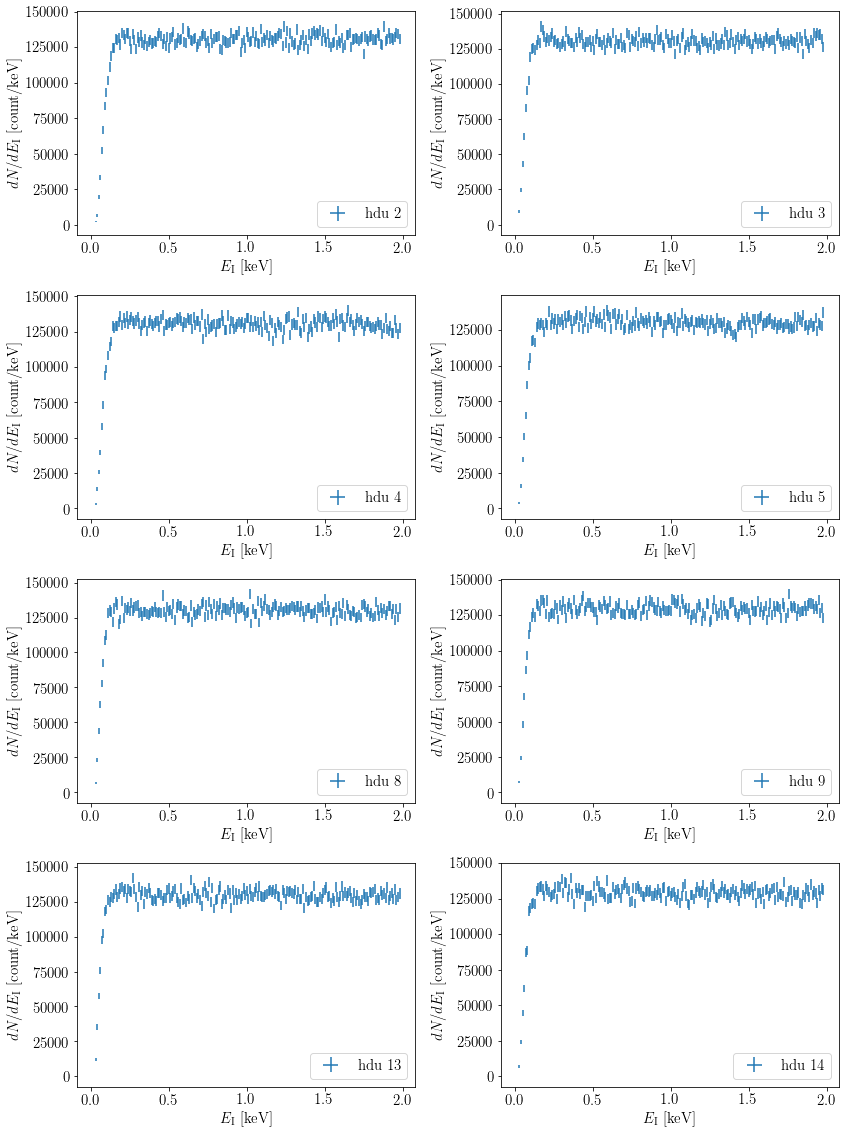

In [558]:
def dNmatch__dE_I( E_I, cut, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("oEnergy", "eV"), "hdu": "ohdu"},
        cut = str(cut*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )
    return data.xhistogram("hdu", centers=E_I, per_bin=True)

dNmatch__dE_I( E_I, run2019.on_excl ).errorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")

### acceptance per hdu

<xarray.Dataset>
Dimensions:             (Ei: 198, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$         (Ei) float64 [keV] 0.01 0.02 0.03 ... 1.96 1.97 1.98
Dimensions without coordinates: Ei
Data variables:
    $\mathcal{A}(E_I)$  (hdu, Ei) object [] 0.0 0.0 ... 0.861+/-0.032


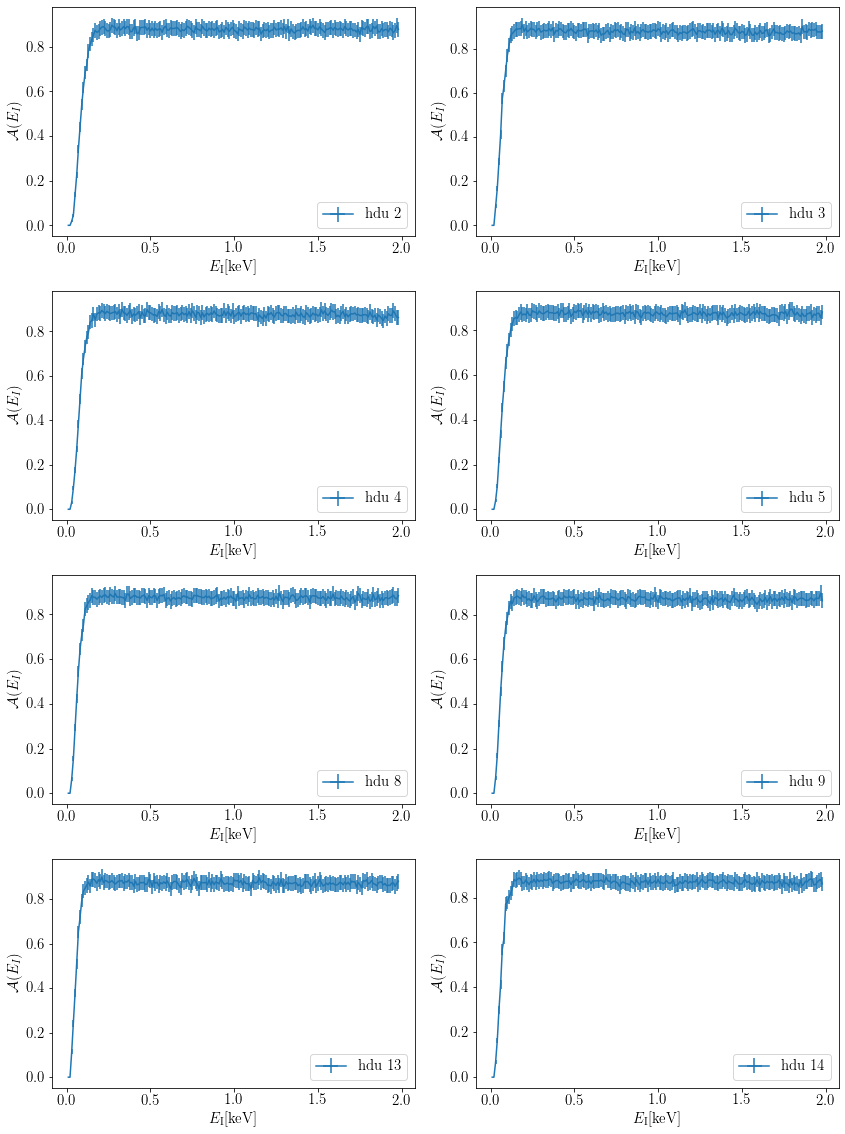

In [568]:
def Acceptance(E_I, cut):
    sim = dNsim__dE_I(E_I, cut)[r"$dN/dE_{\rm I}$"]
    match = dNmatch__dE_I(E_I, cut)[r"$dN/dE_{\rm I}$"]
    sim_where = sim.where(sim.pint.magnitude>0, 1*sim.pint.units)
    match_where = match.where(sim.pint.magnitude>0, 0*sim.pint.units)
    return ia.xr.Dataset(
        data_vars = {r"$\mathcal{A}(E_I)$": match_where/sim_where }
    )

ia.iprint( Acceptance(E_I, run2019.on_excl) ).errorbar(x=r"$E_{\rm I}$", y=r"$\mathcal{A}(E_I)$", z="hdu", cols_wrap=2);

### acceptance fit

fitting function
$$
p_{2} \left(
    \frac{1}{2}\tanh\left( 
        \frac{x-p_1}{p_0}
    \right) + \frac{1}{2}
\right)^{10}
=
p_{2} \text{step}( x-p_1, p_0 )^{10}
$$

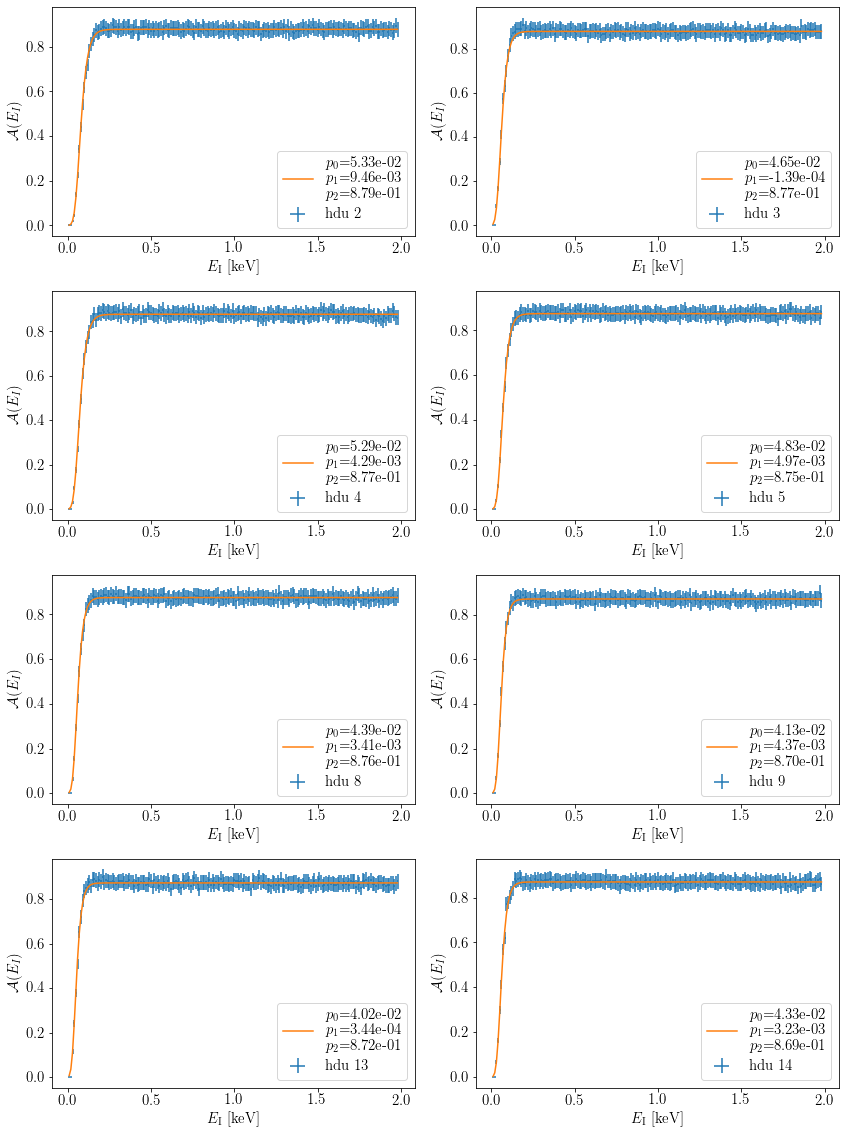

In [575]:
step = lambda x, p: ia.np.tanh(x/p)/2 + 1/2
tanhFit = lambda x, *p, step=step: p[2]*step(x - p[1], p[0])**10
tanhFit_str = "p[2]*step(x - p[1], p[0] )**10"
Acceptance(E_I, run2019.on_excl)[r"$\mathcal{A}(E_I)$"].curve_fit(
    x = r"$E_{\rm I}$", 
    z = "hdu", 
    func = tanhFit,
    p0 = [10,10,10]
).errorbar(x=r"$E_{\rm I}$", z="hdu", cols_wrap=2);

In [583]:
def A_fit( E_I, period, func, p0 ):
    a = Acceptance(E_I, period)[r"$\mathcal{A}(E_I)$"].curve_fit(
        x = r"$E_{\rm I}$", 
        z = "hdu", 
        func = func,
        p0 = p0
    )
    fit = a.attrs["fit"]
    x = E_I.pint.magnitude
    b = [ fit.attrs["func"]( x, *fit.sel(hdu=sel).data ) for sel in fit["hdu"] ]
    return ia.xr.DataArray(
        b, 
        dims=["hdu", *E_I.dims],
        coords = {
            E_I.name: E_I,
            "hdu": a["hdu"]
        }
    )#.set_coords(E_I=E_I, hdu=a["hdu"])

ia.iprint(A_fit(E_I, run2019.on_excl, tanhFit, [10,10,10]));

<xarray.DataArray (hdu: 8, Ei: 200)>
array([[1.24457965e-04, 9.49657760e-04, 5.10688865e-03, ...,
        8.78673118e-01, 8.78673118e-01, 8.78673118e-01],
       [8.82946951e-04, 5.98468292e-03, 2.61835172e-02, ...,
        8.77483315e-01, 8.77483315e-01, 8.77483315e-01],
       [3.68314417e-04, 2.37984666e-03, 1.08200756e-02, ...,
        8.77447514e-01, 8.77447514e-01, 8.77447514e-01],
       ...,
       [2.79043969e-04, 3.03082858e-03, 1.86040163e-02, ...,
        8.69995048e-01, 8.69995048e-01, 8.69995048e-01],
       [7.81818735e-04, 7.05781652e-03, 3.57307496e-02, ...,
        8.72261172e-01, 8.72261172e-01, 8.72261172e-01],
       [3.91987348e-04, 3.58626561e-03, 1.95960609e-02, ...,
        8.69405892e-01, 8.69405892e-01, 8.69405892e-01]])
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: Ei


## acceptance rate

da_errorbar


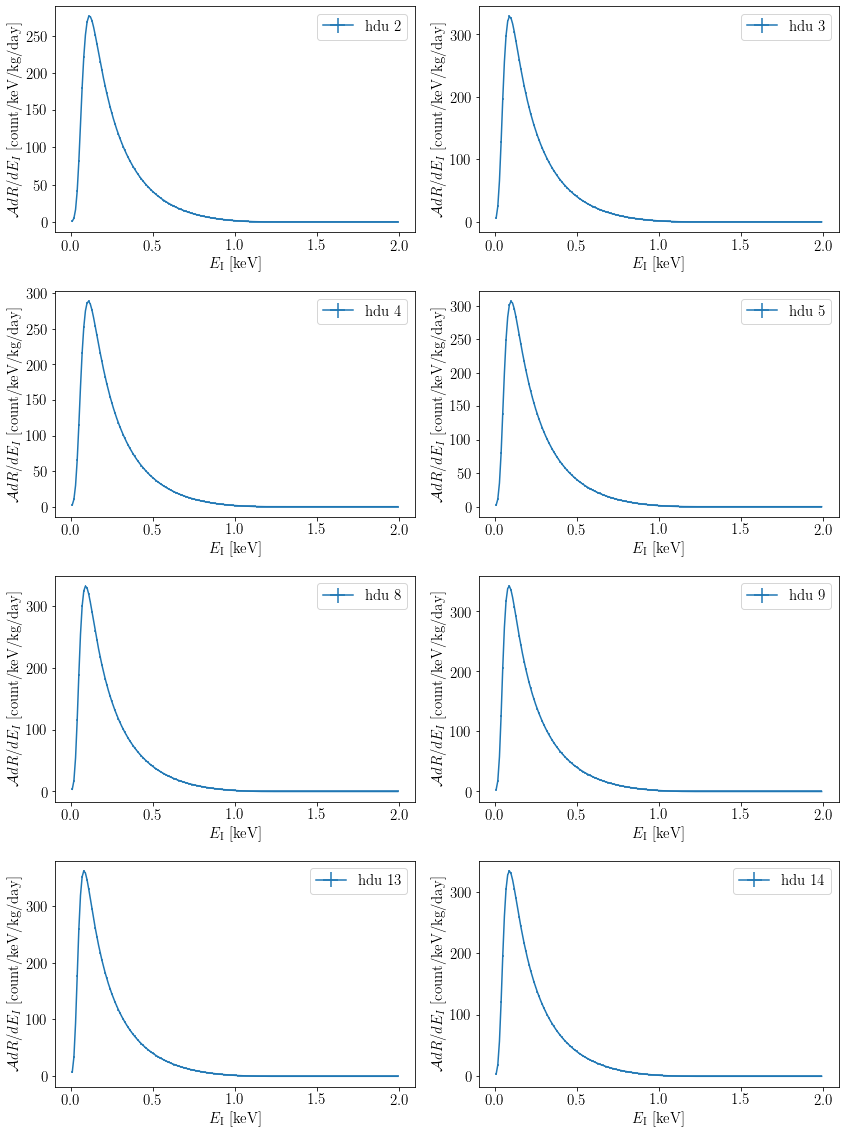

In [755]:
def AdR__dE_I(E_I, Q, flux_nu, period, func=tanhFit, p0=[10,10,10]):
    a = A_fit( E_I, period, func, p0 )
    b = dR__dE_I(E_I, Q, flux_nu)
    return ia.Array(
        name = r"$\mathcal{A}dR/dE_I$",
        data = a * b,
        coords = [a["hdu"], E_I]
    )

( AdR__dE_I(E_I, Q, flux_nu, run2019.on_excl) ).errorbar(
    x=r"$E_{\rm I}$", 
    yunits="count/keV/kg/day",
    z="hdu", 
    fmt="", 
    cols_wrap=2
);

## energy dispersion

Multiple effects contribute for dispcrepancy between the measured energy and the ionization energy.
The main contribution comes from the reconstruction algorithm.
In order to account for it, the reconstructed energy is compared to the simulated energy in the matching catalogs.
Then the rate is corrected by convoluting the ionization energy with the dispersion kernel as
$$
\frac{d^3N_{\rm M} }{dEdMdt}(E_M) = 
\int_{E_{\rm min}}^{\infty} dE_I 
    \mathcal{A}(E_I) \frac{d^3N_{\rm I} }{dEdMdt}(E_I)
    G\left( E_M - E_I - \mu(E_I), \sigma(E_I) \right)
$$

dict_keys([2, 3, 4, 5, 8, 9, 13, 14])


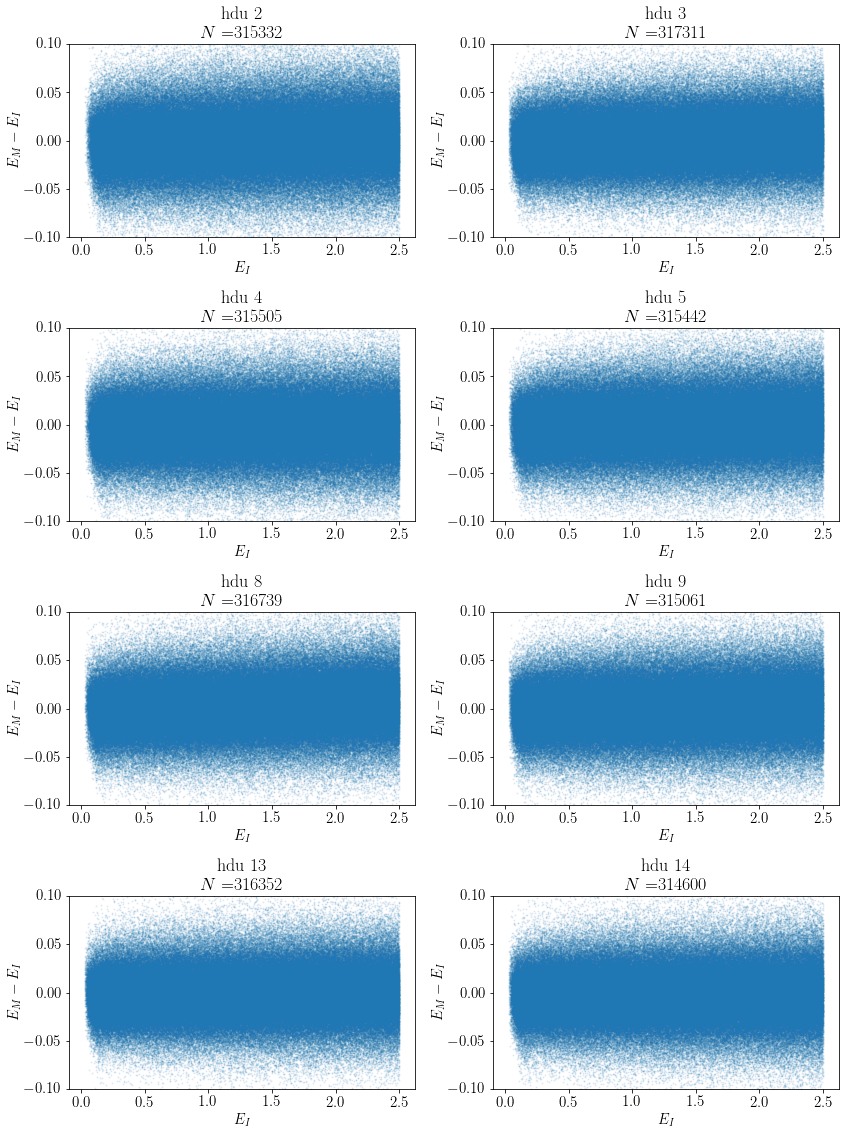

In [635]:
def dispersion_load( period, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {
            "E_I": ("oEnergy", "eV"),
            "E_M": ("E1/gain3Peaks", "keV"),
            "hdu": "ohdu"
        },
        cut = str(period*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )

    E_M = data["E_M"].pint.magnitude
    E_I = data["E_I"].pint.to('keV').pint.magnitude
    ohdu = data["hdu"]
    return dict(E_M=E_M, E_I=E_I, ohdu=ohdu)

def dispersion_per_ohdu( period, distSim=1.5 ):
    data = dispersion_load( period, distSim )
    return {
        ohdu: ia.np.vstack( (data["E_M"], data["E_I"]) )[:, data["ohdu"]==ohdu ] for ohdu in ia.np.unique(data["ohdu"])
    }, ["hdu", "kind", "E"]

def plot_dispersion( period, sel=slice(None, None), cols_wrap=2, distSim=1.5, func=lambda x, y: x ):
    data, dims = dispersion_per_ohdu( period, distSim )
#     print( data.keys() )
    size = len(data)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    for i, (hdu, (e_M, e_I)) in enumerate( list(data.items())[sel] ):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        ax.scatter( e_I, func(e_I, e_M), s=1, alpha=.1 )
        ax.set_xlabel( r"$E_I$" )
        ax.set_ylabel( r"$E_M - E_I$" )
        ax.set_title( f"hdu {hdu}\n$N=${e_M.size}" )
        ax.set_ylim((-.1, .1))
    plt.tight_layout()
    return

delta = lambda x, y: (y-x)
plot_dispersion( run2019.on_excl, distSim=1.5, func=delta )

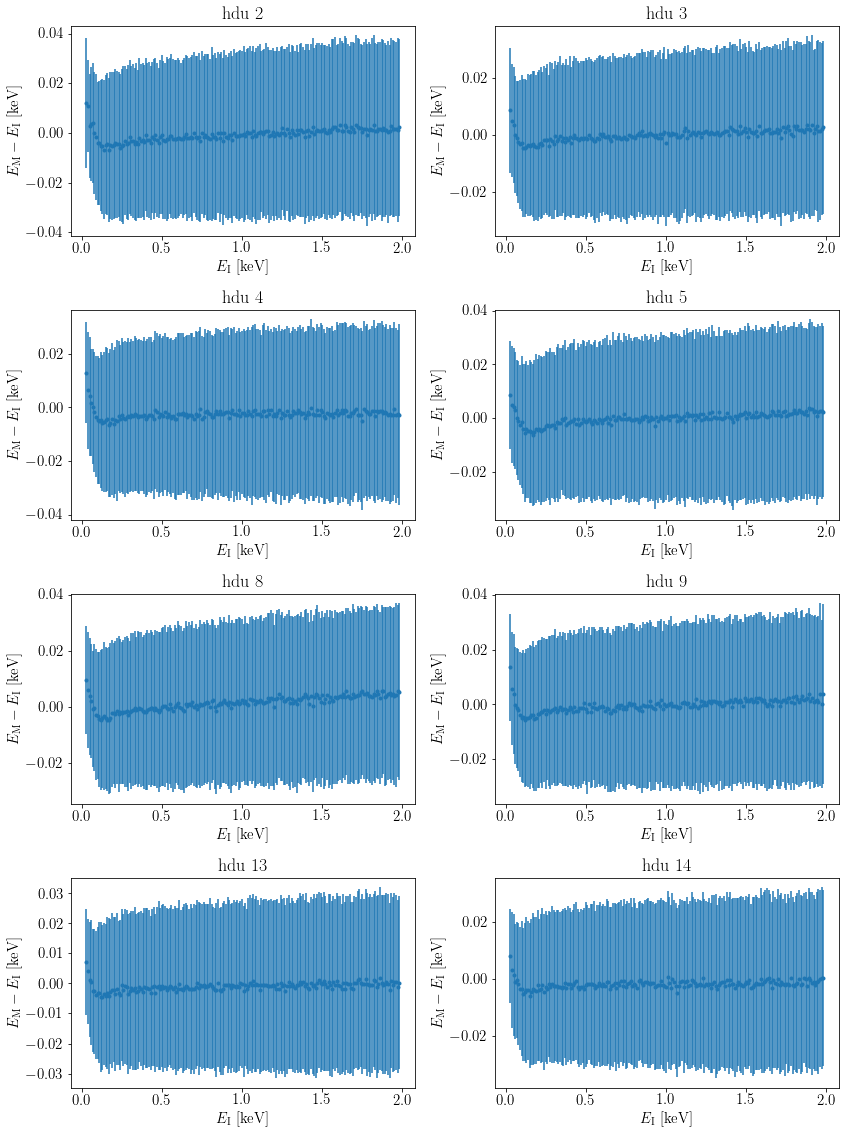

In [637]:
def dispersion_statistics( E_I, period, distSim=1.5 ):
    data, dims = dispersion_per_ohdu( period, distSim )
#     print( data.keys() )
    stats = lambda x: ( x.mean(), x.std() )
    Ebins_keV = ((E_I[:-1] + E_I[1:])/2).pint.to("keV")
    Ebins_mag = Ebins_keV.data.magnitude
    compute = lambda x, y, bins, statistics: (
        ia.binned_statistic( y[abs(y - x)<.2], (x - y)[abs(y - x)<.2], statistic=statistics, bins=bins )[0]
    )
    means = [ compute( e_M, e_I, Ebins_mag, statistics='mean' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]
    stds = [ compute( e_M, e_I, Ebins_mag, statistics='std' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]

    return ia.xr.DataArray(
        ia.np.dstack((means, stds)) * ureg.keV,
        dims = ["hdu", "Ei", "kind"],
        coords = {
            "kind": ["mean", "std"],
            "hdu": list(data.keys()),
            r"$E_{\rm I}$": Ebins_keV[:-1]
        }
    )

def plot_dispersion_statistics( E_I, period, cols_wrap=2 ):
    dataarray = dispersion_statistics(E_I, period )
    hdus = dataarray["hdu"].data
    size = len(hdus)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    
    for i, hdu_data in enumerate( dataarray.sel(hdu=hdus)):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        means = hdu_data.sel(kind="mean")
        stds = hdu_data.sel(kind="std")
        ax.errorbar( E_I.data.to("keV").magnitude[1:-1], means.data.magnitude, yerr=stds.data.magnitude, fmt="." )
        ax.set_xlabel( E_I.name + f" [{E_I.pint.units}]" )
        ax.set_ylabel( r"$E_{\rm M} - E_{\rm I}$" + f" [{E_I.pint.units}]" )
        ax.set_title( f"hdu {hdus[i]}" )
    plt.tight_layout()
    return
        
plot_dispersion_statistics( E_I, run2019.on_excl )

### measured energy rate

da_errorbar


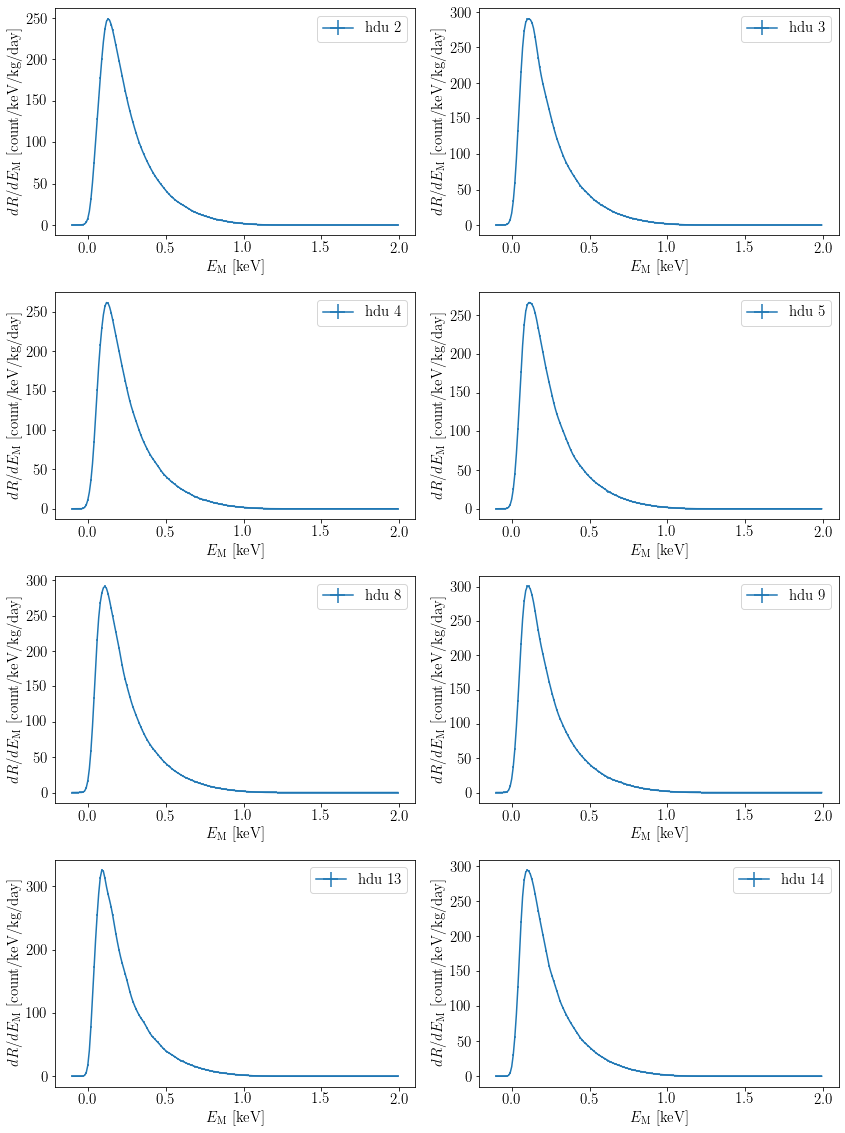

In [756]:
def dR__dE_M( E_M, E_I, Q, flux_nu, period, func=tanhFit, p0=[10,10,10]):
    import scipy
#     import xarray as xr
    a = AdR__dE_I(E_I[1:-1], Q, flux_nu, period, func=tanhFit, p0=[10,10,10])
    stats = dispersion_statistics(E_I, period )
    diffs = E_M - E_I[1:-1] + stats.sel(kind="mean")
    sigma = stats.sel(kind="std")
    G = scipy.stats.norm.pdf( 
        diffs.data.magnitude,
        scale=sigma.data.magnitude.T[None,:,:]
    )
    G = ia.xr.DataArray(
        G,
        dims = ["Em", "Ei", "hdu"],
        coords = {
            "hdu": stats["hdu"],
            r"$E_{\rm M}$": E_M,
            r"$E_{\rm I}$": E_I[1:-1]
        }
    )
    G.data[ia.np.isnan(G.data)] = 0

    ret = ( a*G/ureg.keV ).integrate(r"$E_{\rm I}$")
    ret.name = r"$dR/dE_{\rm M}$"
    return ret

E_M = ia.xr.DataArray( name=r"$E_{\rm M}$", data=ia.arange(-.1, 2, .01) * ureg.keV, dims = "Em" )
dR__dE_M( E_M, E_I, Q, flux_nu, run2019.on_excl ).errorbar(
    x = E_M.name, 
    z = "hdu", 
    yunits = "count/keV/kg/day", 
    fmt = "", 
    cols_wrap = 2
);

## selection efficiency

In [837]:
def dNdata__dE_M( E_M, period ):
    data = ia.genfromroot( 
        run2019.data_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(period*run2019.excluded_ohdu),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

def dNsel__dE_M( E_M, period ):
    data = ia.genfromroot( 
        run2019.data_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(sizell<.95) & (sizell>0) & (E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50) & (xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
        ),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


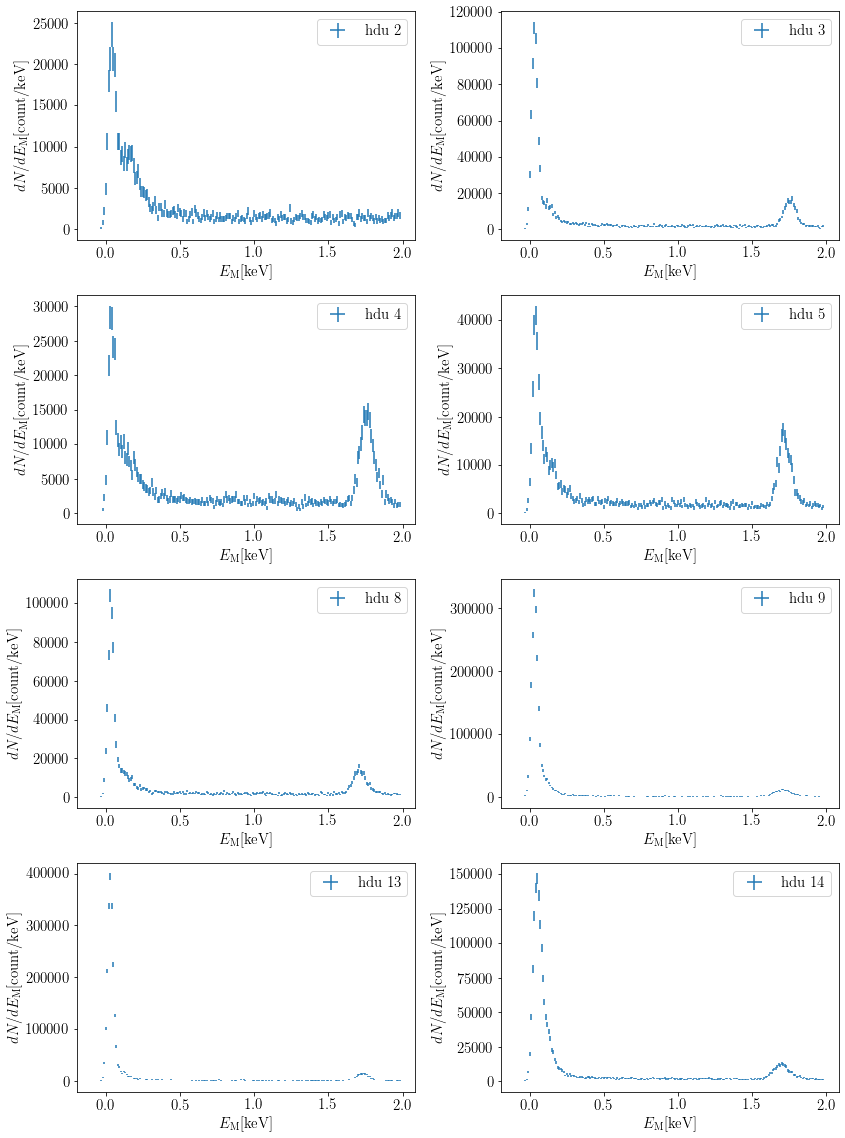

In [652]:
dNdata__dE_M( E_M, run2019.on_excl ).errorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


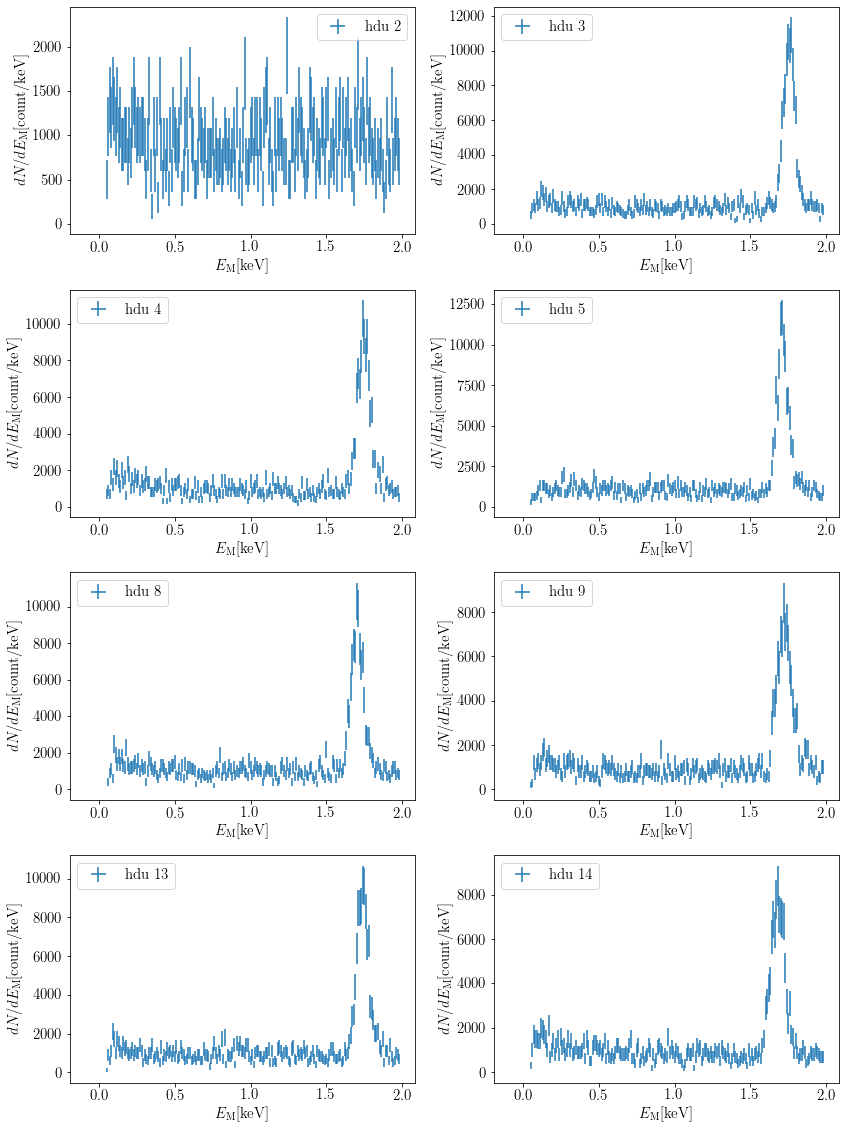

In [653]:
dNsel__dE_M( E_M, run2019.on_excl ).errorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

In [657]:
def dNmatch__dE_M( E_M, cut, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(cut*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

def dNmatchsel__dE_M( E_M, period, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(sizell<.95) & (sizell>0) & (E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50) & (xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'*f'distSim<={distSim}'
        ),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


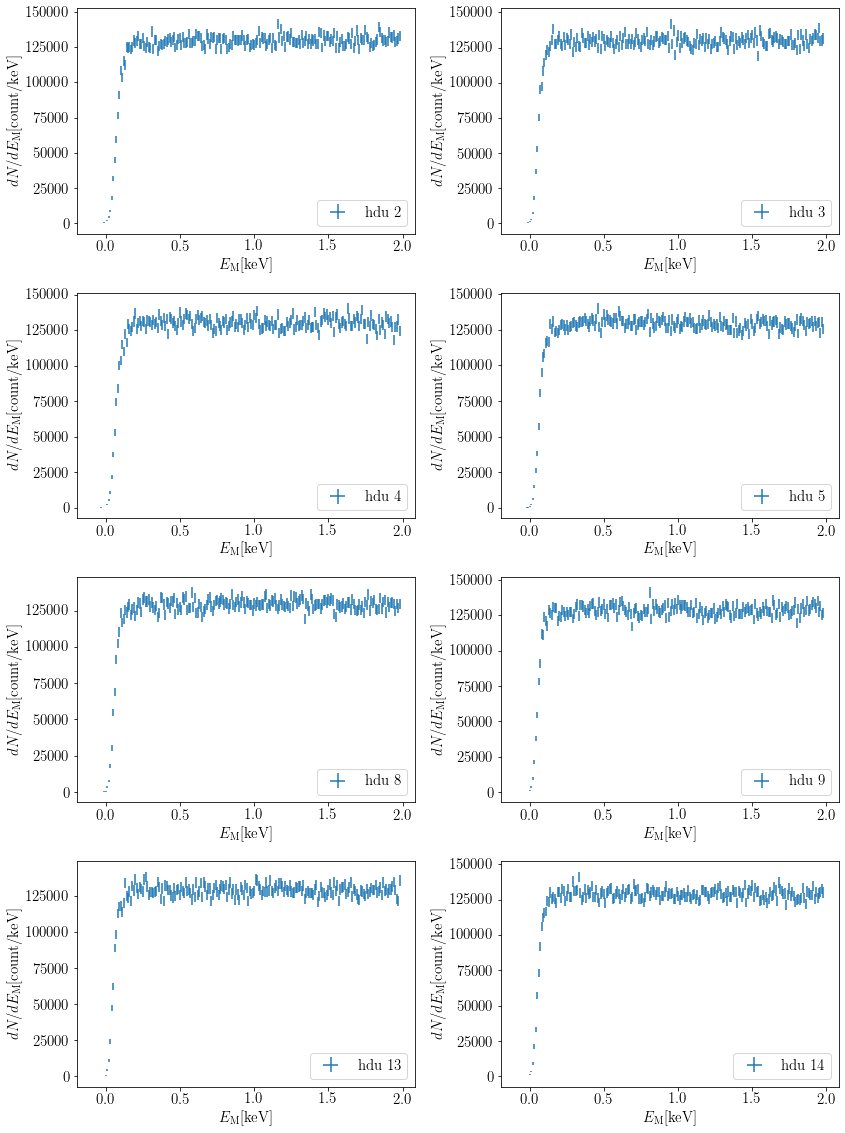

In [658]:
dNmatch__dE_M( E_M, run2019.on_excl ).errorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


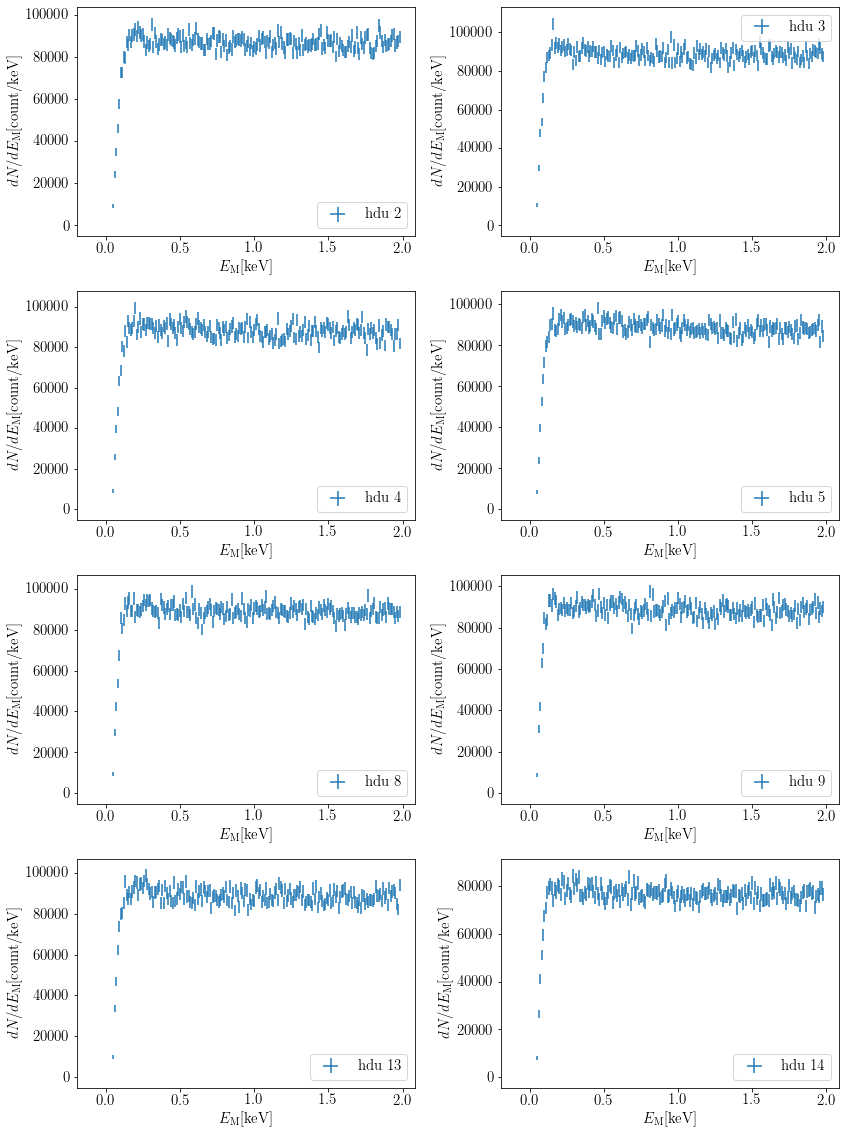

In [659]:
dNmatchsel__dE_M( E_M, run2019.on_excl ).errorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

<xarray.Dataset>
Dimensions:             (Em: 208, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] -0.09 -0.08 -0.07 ... 1.96 1.97 1.98
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.0 0.0 ... 0.588+/-0.027
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


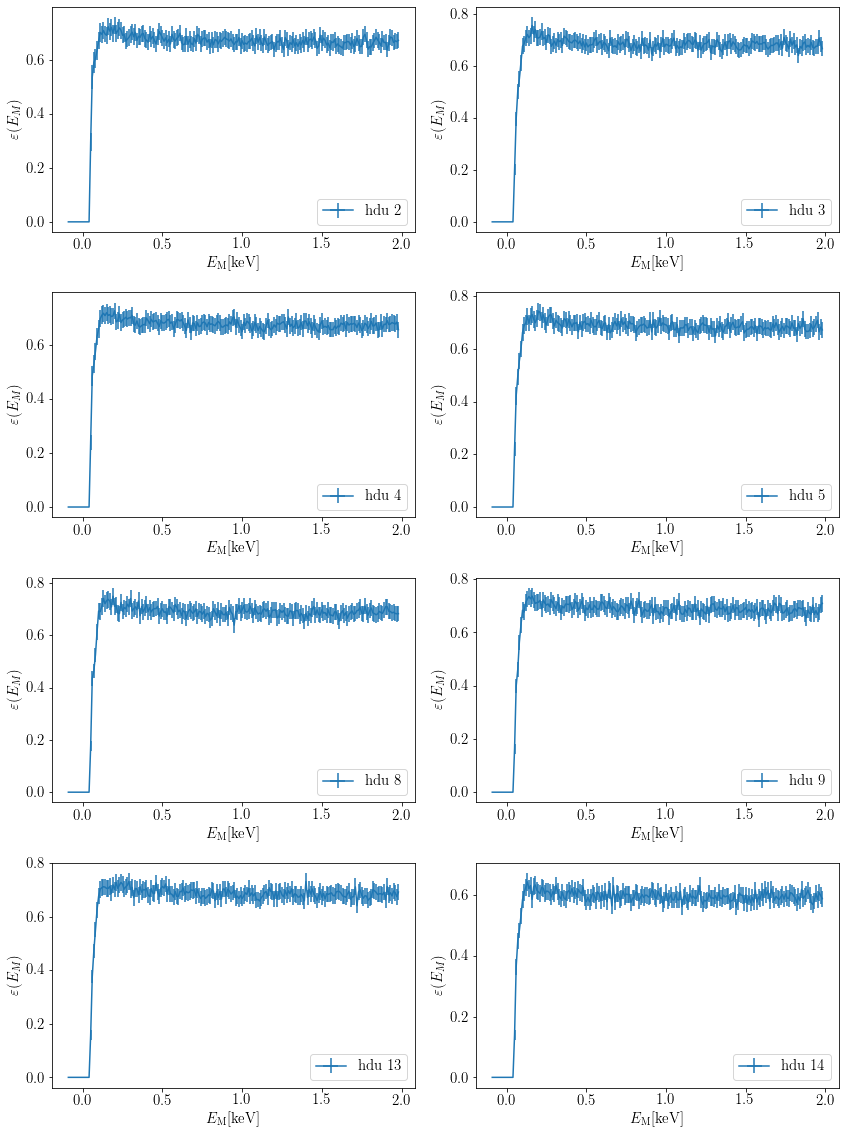

In [662]:
def Efficiency(E_M, cut):
    match = dNmatch__dE_M(E_M, cut)[r"$dN/dE_{\rm M}$"]
    matchSel = dNmatchsel__dE_M(E_M, cut)[r"$dN/dE_{\rm M}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {r"$\varepsilon(E_M)$": matchSel_where/match_where }
    )

ia.iprint( Efficiency(E_M, run2019.on_excl) ).errorbar(x=r"$E_{\rm M}$", y=r"$\varepsilon(E_M)$", z="hdu", cols_wrap=2);

## efficiency rate

da_errorbar


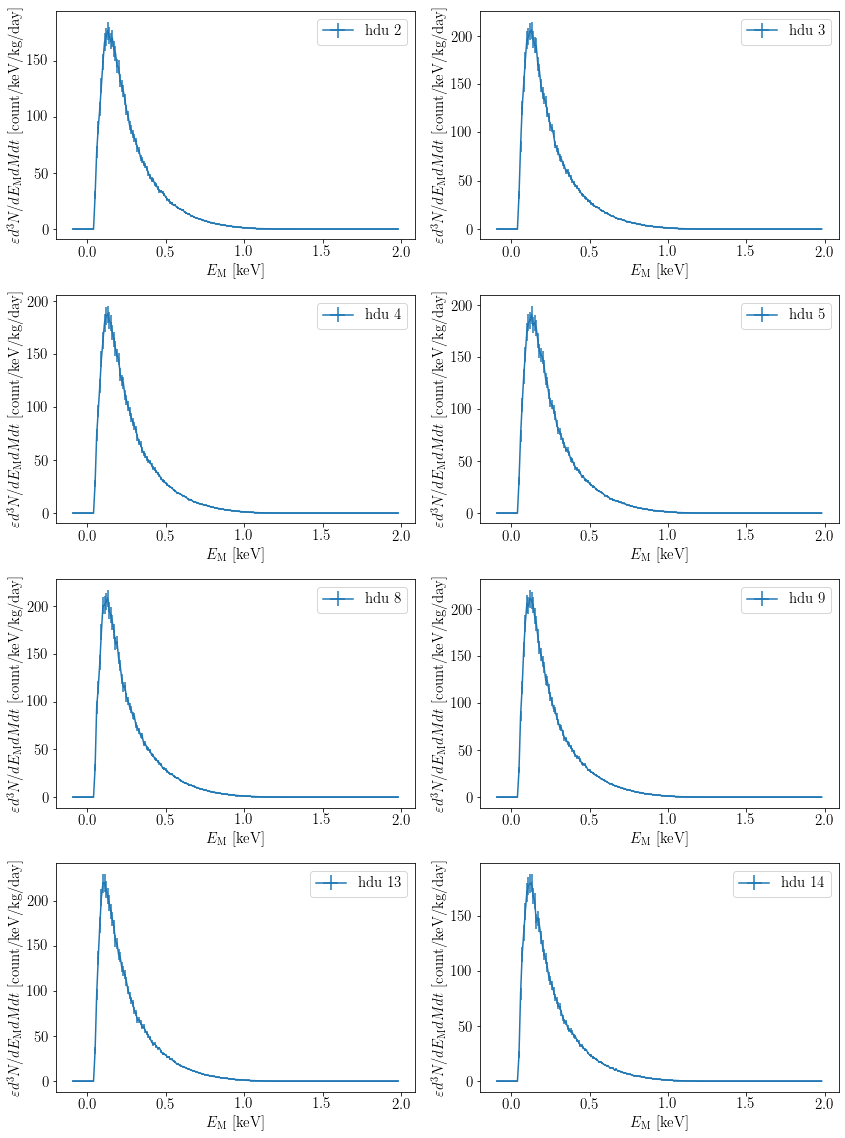

In [758]:
def edR__dE_M(E_M, E_I, Q, flux_nu, period):
    a = Efficiency(E_M, period)[r"$\varepsilon(E_M)$"]
    b = dR__dE_M( E_M, E_I, Q, flux_nu, period )[{"Em":slice(1,-1)}]
    ret = a*b
    ret[r"$E_{\rm M}$"] = E_M[1:-1]
    ret.name = r"$\varepsilon d^3N/dE_{\rm M}dMdt$"
    return ret

finalRate = edR__dE_M(E_M, E_I, Q, flux_nu, run2019.on_excl)
finalRate.errorbar(
    x=r"$E_{\rm M}$", 
    yunits="count/keV/kg/day",
    z="hdu", 
    fmt="", 
    cols_wrap=2,
);

## rebinned rate

In [876]:
_ = ia.arange(.05,1,0.13)*ia.ureg.keV
Ebins = ia.xr.DataArray( name=r"$E$", data=_, dims="E" )
print( Ebins )

<xarray.DataArray '$E$' (E: 8)>
<Quantity([0.05 0.18 0.31 0.44 0.57 0.7  0.83 0.96], 'kiloelectron_volt')>
Dimensions without coordinates: E


da_errorbar


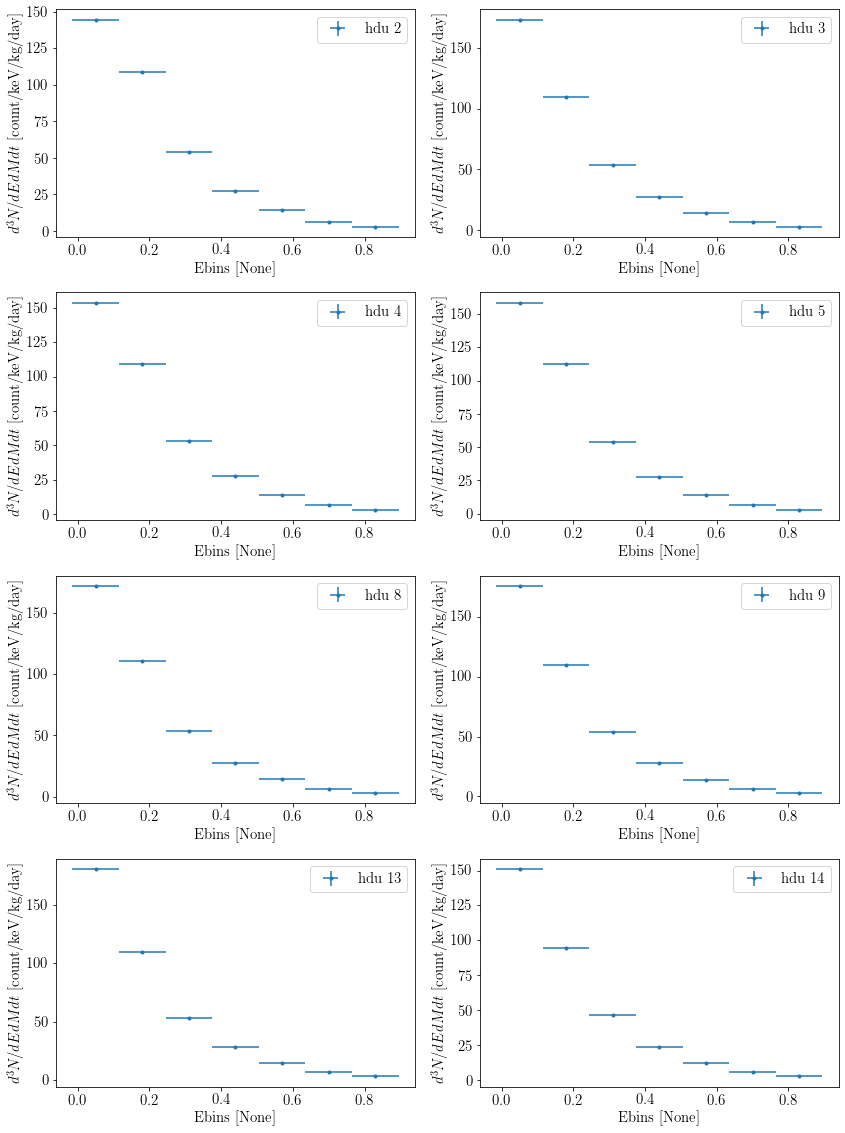

In [877]:
def rebin( rate, Ebins ):
    units = rate.pint.units
#     print( units )
    data = [ 
        ia.binned_statistic( 
            data.coords[r"$E_{\rm M}$"].pint.magnitude, 
            ia.un.nominal_values(data.pint.magnitude), 
            statistic = "mean", 
            bins = Ebins.pint.magnitude 
        )[0]
        for hdu in finalRate["hdu"] for data in [rate.loc[{"hdu":hdu.data}]]
    ]
    ret = ia.xr.DataArray(
        name = r"$d^3N/dEdMdt$",
        data = ia.np.array(data) * units,
        dims = ["hdu", "Ebins"],
    )
    ret["hdu"] = rate["hdu"]
#     print( Ebins.data[:-1] )
    ret["Ebins"] = Ebins.data.magnitude[:-1]
    return ret

rebin( finalRate, Ebins ).errorbar(
    x=r"Ebins", 
    yunits="count/keV/kg/day",
    z="hdu", 
    fmt=".", 
    cols_wrap=2,
);

In [816]:
measured_rate = dR__dE_M( E_M, E_I, Q, flux_nu, run2019.on_excl )

In [792]:
acceptance_rate = AdR__dE_I(E_I, Q, flux_nu, run2019.on_excl)

In [798]:
ionization_rate = dR__dE_I( E_I, Q, flux_nu )

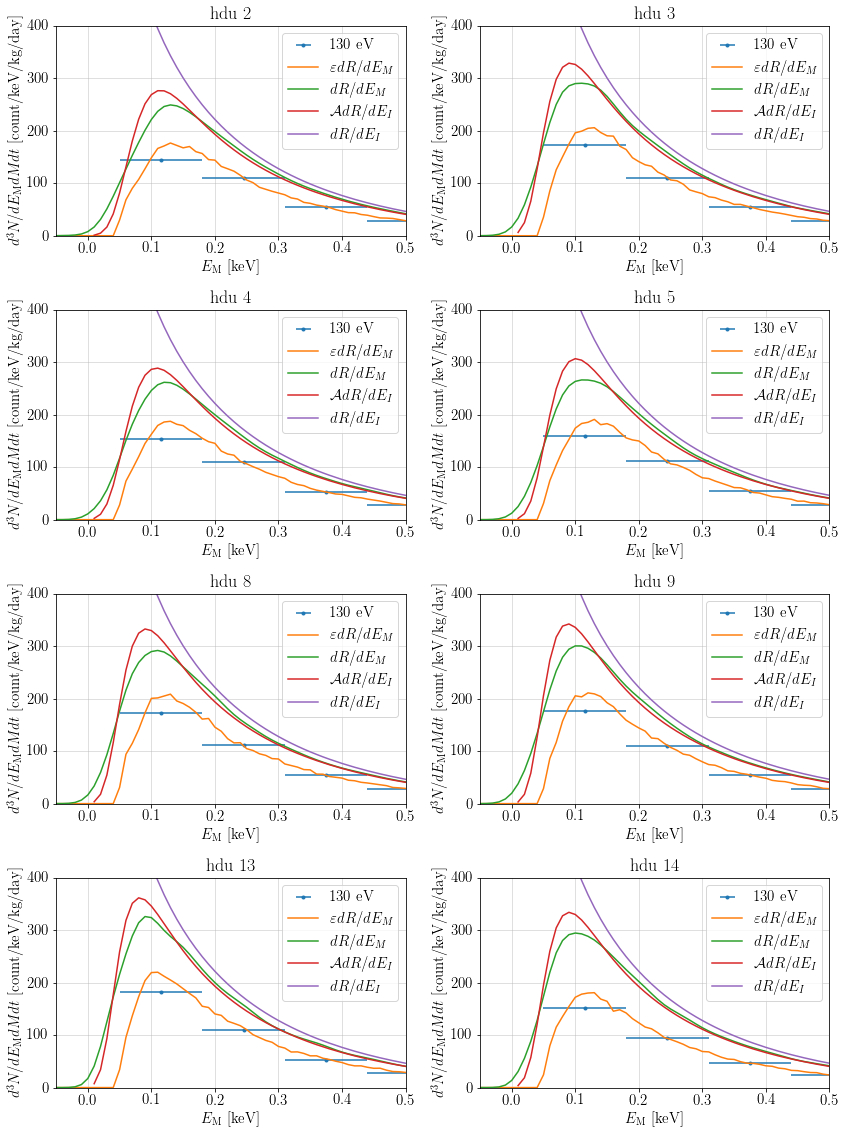

In [801]:
rebinRate = rebin( finalRate, Ebins )

z = "hdu"
size = rebinRate[z].size
cols_wrap = 2
nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
width, height = plt.rcParams["figure.figsize"]
fig = plt.figure( figsize = (width*ncols, height*nrows) )        
for i, hdu in enumerate(rebinRate["hdu"]):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.set_title(f"hdu {hdu.data}")
    ax.set_xlabel(r"$E_{\rm M}$ [keV]")
    ax.set_ylabel(r"$d^3N/dE_{\rm M}dMdt$ [count/keV/kg/day]")
    ax.errorbar( 
        x = rebinRate["Ebins"] + .13/2, 
        y = rebinRate[{"hdu":i}].data.to("count/keV/kg/day").magnitude, 
        xerr = .13/2,
        fmt = ".",
        label = f"130 eV Ch"
    )
    ax.errorbar( 
        x = finalRate[r"$E_{\rm M}$"].pint.magnitude, 
        y = ia.un.nominal_values( finalRate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = fr"$\varepsilon dR/dE_M$"
    )
    ax.errorbar( 
        x = measured_rate[r"$E_{\rm M}$"].pint.magnitude, 
        y = ia.un.nominal_values( measured_rate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = fr"$dR/dE_M$"
    )
    ax.errorbar( 
        x = acceptance_rate[r"$E_{\rm I}$"].pint.magnitude, 
        y = ia.un.nominal_values( acceptance_rate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = r"$\mathcal{A}dR/dE_I$"
    )
    ax.errorbar( 
        x = ionization_rate[r"$E_{\rm I}$"].pint.magnitude, 
        y = ia.un.nominal_values( ionization_rate.data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = r"$dR/dE_I$"
    )
    ax.set_xlim((-.05,.5))
    ax.set_ylim((0,400))
    ax.grid(True)
    plt.legend()
fig.tight_layout()

da_errorbar


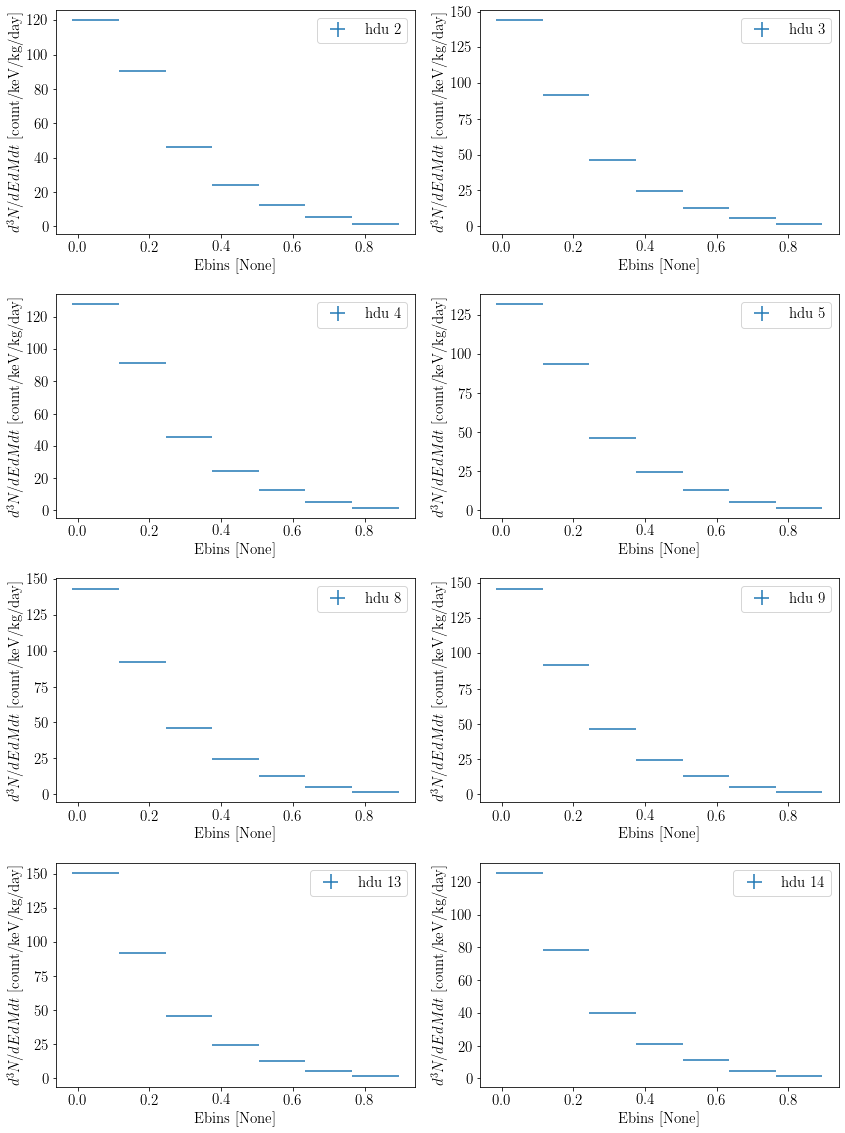

In [817]:
Lindhard = edR__dE_M(E_M, E_I, Q_Lindhard, flux_nu, run2019.on_excl)
rebin( Lindhard, Ebins ).errorbar(
    x=r"Ebins", 
    yunits="count/keV/kg/day",
    z="hdu", 
    fmt=" ", 
    cols_wrap=2,
);

# Differential Rate

In [861]:
_ = ia.arange(.05-0.13/2,1,0.13)*ia.ureg.keV
Ebins = ia.xr.DataArray( name=r"$E$", data=_, dims="E" )
print( Ebins )

<xarray.DataArray '$E$' (E: 8)>
<Quantity([-0.015  0.115  0.245  0.375  0.505  0.635  0.765  0.895], 'kiloelectron_volt')>
Dimensions without coordinates: E


In [855]:
rho = 2.33 *ia.ureg('g/cm^3') #kg/m^3
dM = rho * (15*ia.ureg('micrometer'))**2 * 675*ia.ureg("micrometer") * 4120**2
dM = dM.to('kg')
print( dM )


0.00600670971 kg


In [849]:
Ton = 735/24* ia.ureg("day")
Toff = 652/24* ia.ureg("day")

<xarray.Dataset>
Dimensions:  (E: 6, hdu: 8)
Coordinates:
  * hdu      (hdu) int32 2 3 4 5 8 9 13 14
    $E$      (E) float64 [keV] 0.115 0.245 0.375 0.505 0.635 0.765
Dimensions without coordinates: E
Data variables:
    $dN/dE$  (hdu, E) object [count/d/keV/kg] (1.4+/-0.7)e+03 ... (0+/-6)e+02
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


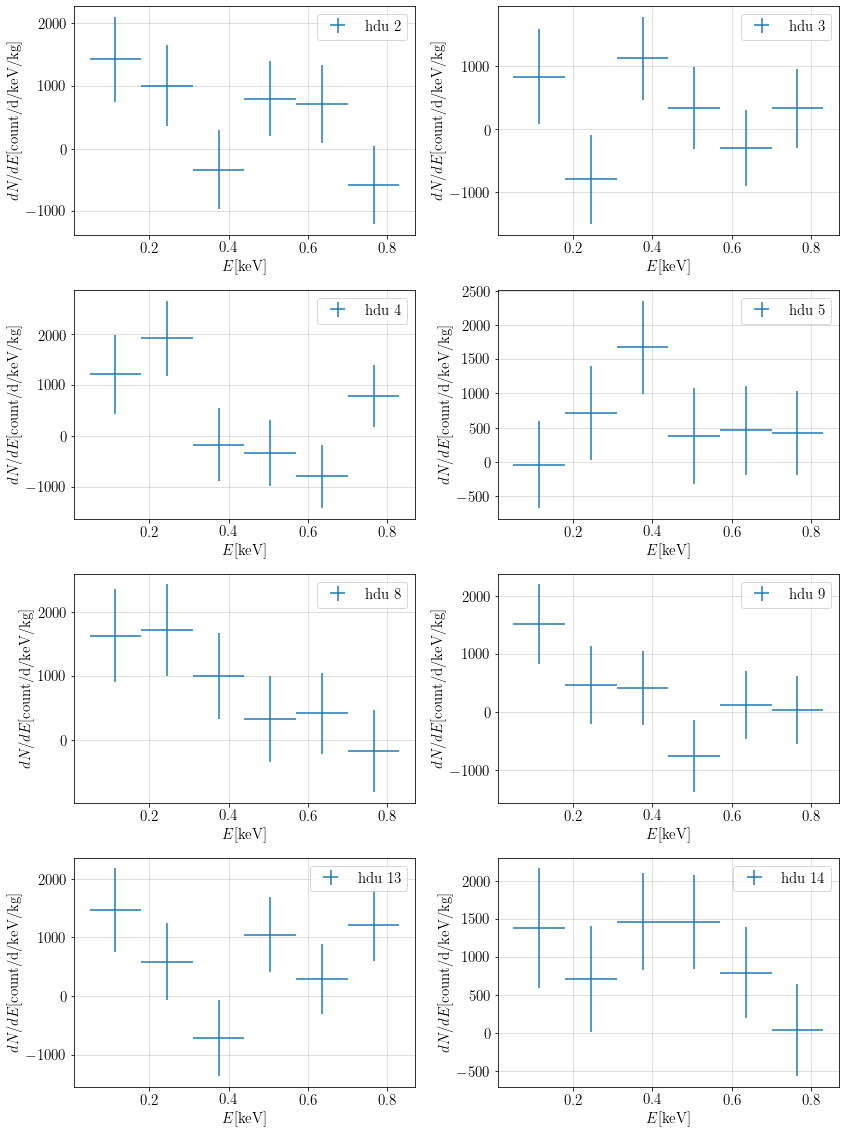

In [864]:
ia.iprint( 
    (dNsel__dE_M( Ebins, run2019.on_excl )/dM/Ton - dNsel__dE_M( Ebins, run2019.off_excl )/dM/Ton)
).errorbar( 
    x = r"$E$", 
    y = r"$dN/dE$", 
    z = "hdu", 
    fmt = " "
)

# Measured Differential Rate ON─OFF

In [822]:
def get_array( file, expressions=None,  ):
    return uproot.concatenate( f'{pattern["data"]}:hitSumm', expressions=expressions, cut=cut )['runID']

In [823]:
def print_header(func):
    def wrapper(*args, **kwargs):
        print( f"{args[0].__class__.__name__}.{func.__name__}" )
        return func(*args, **kwargs)
    return wrapper

def safediv(a, b):
    ret = zeros_like( a )
    ret[ a!=0 ] = a[ a!=0 ]/b[ a!=0 ]
    return ret

def composekwargs(f, g):
    return lambda **kwargs: f(g(**kwargs), **kwargs)


In [824]:
from numpy import *
import types
import uproot4 as uproot
import matplotlib.pyplot as plt
from copy import deepcopy

class LazyPlottable:
    def __init__(self):
        pass
    
    def plot(self, label=None, fig=None, ax=None, **kwargs):
        show = False
        if ax is None:
            if fig is None:
                print("create figure")
                fig = plt.figure()
                show = True
            print("create axis")
            ax = fig.add_subplot()
        ax.grid(True)
        if not "dx" in kwargs:
            raise Exception("needs dx argument")
        if not "xlabel" in kwargs:
            ax.set_xlabel( self.xlabel(**kwargs) )
        if not "xlabel" in kwargs:
            ax.set_ylabel( self.ylabel(**kwargs) )
        if "yscale" in kwargs:
            ax.set_yscale(kwargs["yscale"])

        ax.errorbar( 
            self.x(**kwargs), 
            self.y(**kwargs), 
            xerr=self.xerr(**kwargs), 
            yerr=self.yerr(**kwargs), 
            label=self.label(**kwargs), 
            fmt=' ' 
        )
        
        if show:
            plt.legend()
            plt.show()
        return self

    

In [825]:
pattern = '/share/storage2/connie/DAna/nuCatalogs/shape_*_data_[6-7]*_to_*_v4.0.root'
class SelectedData(LazyPlottable):
    def __init__(self, label, selections):
        self._initlabel = label
        self.selections = selections
        self.funclist = [self.load_data]
        self.kwargs = None
        
    def load_data(self, **kwargs):
        if not hasattr(self, "data"):
            print(f"load data {self._initlabel}")
            self.ohdus = kwargs["ohdus"]
            self.cuts = kwargs["cuts"]
            ohdu_cuts = list(map(lambda ohdu:f"(ohdu=={ohdu})", self.ohdus))
            selections = self.selections + [ f"({'|'.join(ohdu_cuts)})"]
            selections += self.cuts
            cuts = "&".join(selections)
            self.data = uproot.concatenate(
                f"{pattern}:hitSumm", 
                expressions=["E", "runID", "ohdu"], 
                aliases={"E":"E1/gain3Peaks"}, 
                cut=cuts, 
                library="np"
            )
            self.dx = kwargs["dx"]
            self.bins = arange(kwargs["xmin"], kwargs["xmax"] + self.dx, self.dx)
            self._x = (self.bins[1:] + self.bins[:-1])/2
            self._xerr = self.dx/2
            self._y = array([ 
                histogram( self.data["E"][self.data["ohdu"]==ohdu], self.bins )[0] 
                for ohdu in self.ohdus 
            ])
            self._yerr = sqrt(self._y)
            self._xlabel = "energy [keV]"
            self._ylabel = "counts"
            self._label = self._initlabel
        return
    
    def x(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._x

    def xerr(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._xerr

    def y(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._y

    def yerr(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)      
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._yerr

    def label(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._label

    def xlabel(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._xlabel

    def ylabel(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._ylabel
    
    def get_ohdu(self, ohdu):
        print(f"lazy get ohdu{ohdu}")
        def func(**kwargs):
            print(f"call get ohdu{ohdu}")
            self._label = fr"{self._label}{ohdu}"
            self._y = self._y[ self.ohdus.index(ohdu) ]
            self._yerr = self._yerr[ self.ohdus.index(ohdu) ]
            self.ohdus = ohdu
            return
        self.funclist.append( func )
        return self
            
    def average(self):
        def func(**kwargs):
            print("average")
            self._label = fr"$\langle${self._label}$\rangle$"
            w = safediv( self._yerr, self._yerr**3 ) #1/yerr**2
            self._y = sum( self._y*w, axis=0 )/sum( w, axis=0 )
            self._yerr = sqrt( sum( (self._yerr*w)**2, axis=0 ) )/sum( w, axis=0 )
            self.ohdus = []
            return
        self.funclist.append( func )
        return self

    def sum(self):
        def func(**kwargs):
            print("sum")
            self._label = fr"sum({self._label})"
            self._y = sum( self._y, axis=0 )
            self._yerr = sqrt( sum( self._yerr**2, axis=0 ) )
            self.ohdus = []
            return
        self.funclist.append( func )
        return self

    def rate(self):
        print("lazy rate")
        def func(**kwargs):
            print("call rate")
            self._label = fr"Rate({self._label})"
            rho = 2.42*1e-3*(1e2)**3 #kg/m^3
            dM = rho * (15*1e-6)**2 * 675*1e-6 * 4120**2
#             dM *= len(self.ohdus)
            dT = len( unique(self.data["runID"]) )/24
            print( "dx", self.dx )
            self._y = self._y/dM/dT/self.dx
            self._yerr = self._yerr/dM/dT/self.dx
            self._ylabel = fr"rate [events/kg/day/keV]"
            return
        self.funclist.append( func )
        return self

    def __sub__(self, other):
        print("lazy sub")
        obj = SelectedData("", "")
        def func(**kwargs):
            print("call sub")
            self.ohdus = other.ohdus = obj.ohdus = kwargs["ohdus"]
            self.cuts = other.cuts = obj.cuts = kwargs["cuts"]
            y1, y2 = self.y(**kwargs), other.y(**kwargs)
            yerr1, yerr2 = self.yerr(**kwargs), other.yerr(**kwargs)
            obj._label = fr"{self._label}$-${other._label}"
            obj._x = self._x
            obj._xerr = self._xerr
            obj._xlabel = self._xlabel
            obj._ylabel = self._ylabel
            obj._y = y1 - y2
            obj._yerr = sqrt( yerr1**2 + yerr2**2 )
            return
        obj.funclist = [func]
        return obj
    
class Data:
    def __getitem__(self, indexes):
        if not type(indexes) == tuple:
            runID = indexes
            ohdus = None
        else:
            runID, ohdus = indexes
        
        cuts = []
        if not runID is None:
            if type(runID) is int:
                cuts.append( f"(runID=={runID})" )
            elif type(runID) is dict:
                label = list(runID.keys())[0]
                cuts.extend( runID.values() )
            else:
                cuts.append( runID )
                
        return SelectedData(label, cuts)


In [826]:
class Group:
    def __init__(self, *args):
        self.elements = args
        
    def __getattribute__(self, attr):
        if attr.startswith("_"):
            return object.__getattribute__(self, attr)
        if attr in object.__getattribute__(self, "__dir__")():
            return object.__getattribute__(self, attr)        
        print( "distribute", attr )
        return lambda *args, **kwargs: Group( *[ element.__getattribute__(attr)(*args, **kwargs) for element in object.__getattribute__(self, "elements") ] )
        
#     @print_header
    def plot(self, *args, **kwargs):
        fig = plt.figure()
        ax = fig.add_subplot()
        for element in self.elements:
            element.plot( *args, fig=fig, ax=ax, **kwargs )
        plt.legend()
        plt.show()
        plt.close()
    

In [827]:
ON2019 = {'ON': '( ((runID>6030) & (runID<6227)) | ((runID>6974) & (runID<7522)) )'}
OFF2019 = {'OFF': '(runID>6226) & (runID<6975)'}
OHDUs = [2,3,4,5,8,9,13,14]

excluded = [6415, 6475, 6499, 6926, 6927, 6031, 6093, 6096, 6139, 7074, 7222, 7226, 7374]
excluded_cut = ' & '.join(map(lambda s: f'(runID!={s})', excluded))
ohdu_cut = '(' + ' | '.join(map(lambda s: f'(ohdu=={s})', OHDUs)) + ')'
efficiency_cuts = [ 
    excluded_cut, 
    '(sizell<.95) & (sizell>0)', 
    '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)', 
    '(E0/gain3Peaks>.045) & (E1/gain3Peaks>.05)', 
]

connie = Data()

lazy rate
lazy rate
lazy sub
distribute get_ohdu
lazy get ohdu2
call sub
load data ON
call rate
dx 0.13
load data OFF
call rate
dx 0.13
call get ohdu2


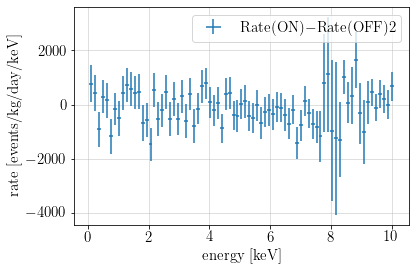

distribute average
load data ON
average
load data OFF
average


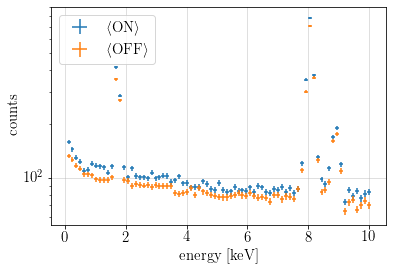

distribute rate
lazy rate
lazy rate
distribute average
load data ON
call rate
dx 0.13
average
load data OFF
call rate
dx 0.13
average


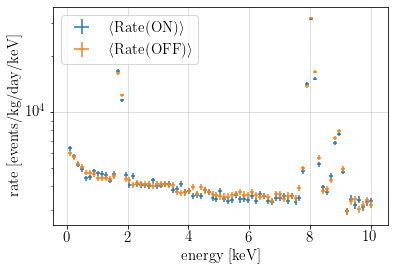

In [828]:
Group(connie[ON2019].rate() - connie[OFF2019].rate()).get_ohdu(2).plot(
    xmin=.05, 
    xmax=10, 
    dx=.13, 
#     yscale="log", 
    cuts=efficiency_cuts,
    ohdus=OHDUs,
)
Group(connie[ON2019], connie[OFF2019]).average().plot(
    xmin=.05, 
    xmax=10, 
    dx=.13, 
    yscale="log", 
    cuts=efficiency_cuts,
    ohdus=OHDUs,
)
Group(connie[ON2019], connie[OFF2019]).rate().average().plot(
    xmin=.05, 
    xmax=10, 
    dx=.13, 
    yscale="log", 
    cuts=efficiency_cuts,
    ohdus=OHDUs,
)

lazy rate
lazy rate
lazy sub
call sub
load data ON
call rate
dx 0.13
load data OFF
call rate
dx 0.13
average


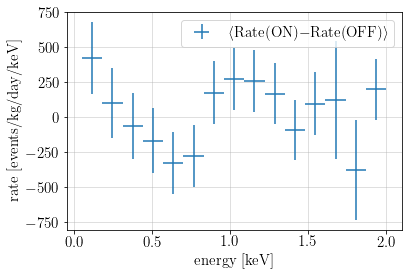

In [830]:
ax = plt.figure().add_subplot()
for dx in [.13]:
    ( connie[ON2019].rate() - connie[OFF2019].rate() ).average().plot(
        xmin=.05, 
        xmax=2, 
        dx=dx, 
        cuts=efficiency_cuts,
        ohdus=OHDUs,
        ax=ax,
    )
plt.legend()
plt.show()